Import Dependencies

In [3]:
import pandas as pd
import numpy as np

## Load Dataset

Movie Review

In [4]:
import os
from eraserbenchmark.rationale_benchmark.utils import load_documents, load_datasets, annotations_from_jsonl, Annotation

data_root = os.path.join('eraserbenchmark/data', 'movies')
documents = load_documents(data_root)
train, val, test = load_datasets(data_root)

In [3]:
data_raw = train[5]
data_raw.__dict__

{'annotation_id': 'negR_005.txt',
 'query': 'What is the sentiment of this review?',
 'evidences': frozenset({(Evidence(text='also unimpressive', docid='negR_005.txt', start_token=631, end_token=633, start_sentence=30, end_sentence=31),),
            (Evidence(text='it is a very bad mistake to make', docid='negR_005.txt', start_token=107, end_token=115, start_sentence=6, end_sentence=7),),
            (Evidence(text='sadly what follows is not really up to the buildup', docid='negR_005.txt', start_token=549, end_token=559, start_sentence=26, end_sentence=27),),
            (Evidence(text='tacky looking rundown martian mining colony', docid='negR_005.txt', start_token=405, end_token=411, start_sentence=19, end_sentence=20),),
            (Evidence(text='that still does not make for a really good science fiction experience', docid='negR_005.txt', start_token=218, end_token=230, start_sentence=11, end_sentence=12),),
            (Evidence(text='these are standard haunted house film shock e

In [5]:
import string
def obtain_text_review(data_raw, documents, token_length=256):
    word_list = [word for sent in documents[data_raw.annotation_id][:token_length] for word in sent+["\n"]][:token_length]
    word_list_refined = [" "+word if word not in string.punctuation else word for word in word_list ]
    paragraph = "".join(word_list_refined)[1:]
    return paragraph

from collections import Counter
data_split = train
token_length = 1000
label_types = {'POS':'positive', 'NEG':'negative'}

df = pd.DataFrame(columns=['review', 'label'])
for data_raw in data_split:
    review = obtain_text_review(data_raw, documents, token_length)
    label = data_raw.classification
    df.loc[len(df)] = [review, label_types[label]]

counts = df['label'].value_counts()
counts

negative    800
positive    800
Name: label, dtype: int64

## Get Explanations

### GPT explanation

In [6]:
# imports
import os
import ast  # for converting embeddings saved as strings back to arrays
import openai  
import pandas as pd
import tiktoken  # for counting tokens
from tqdm.auto import tqdm
from scipy import spatial  # for calculating vector similarities for search
openai.api_key = os.environ["OPENAI_API_KEY"]

# models
EMBEDDING_MODEL = "text-embedding-ada-002"
# GPT_MODEL = "gpt-3.5-turbo-16k-0613"
GPT_MODEL = "gpt-4-0613" # According to OpenAI, GPT-4 is more responsive to system messages, whereas 3.5 would rely on more of the user input.


In [6]:
def summarize(input_premise, is_query=False, n_reviews=None):
    if is_query:
        query = input_premise
        n_reviews = n_reviews
    else:
        query = []
        for x in input_premise:
            query.append(f">>>Review starts\n{x}\n>>>Review ends\n")
        query = "\n".join(query)
        n_reviews = len(input_premise)
    # Please shorten each of the following movie reivews in between 48-96 words in the tone of the reviewer while trying to preserve its meanings.

    sys_msg = f"""
    Please extract the opinions and rewrite the following movie reviews pretending you are the original reviewer, each in about 32 words. 
    Note: Treat each review independently. The start and end of an review is marked by ">>>Review starts" and ">>>Review ends".

    Reply in the following format: 
    The response to each review contains 1 line, which is the shortened version of the review.
    If there are more than 2 reviews, the replies should be are serparated by a new line of "---".
    
    If you feel impossible to summary, please put "I can't summary this review" at the corresponding line.
    The followings are examples of valid replies:
    
    your summary 1
    ---
    I can't summary this review
    ---
    your summary 3
    """

    response = openai.ChatCompletion.create(
            messages=[
                {'role': 'system', 'content': sys_msg},
                {'role': 'user', 'content': query},
            ],
            model=GPT_MODEL,
            temperature=0,
        )

    model_response = response['choices'][0]['message']['content']
    reply_counts = model_response.count("\n---")
    try:
        assert reply_counts+1 == n_reviews
    except AssertionError:
        print(">>>>>>>>>>>>AssertionError:")
        print(f"number of replies {reply_counts+1} does not match number of reviews {n_reviews}")
        print(query)
        print(model_response)
        raise AssertionError
    summarized_reviews = model_response.split("\n---\n")
    return summarized_reviews

summaries_list = []
batch_size = 5
sample_size = 120



new_df = df.sample(120).copy().reset_index(drop=True)
for i in tqdm(range(0, sample_size, batch_size)):
    summaries_list.extend(summarize(df.review[i:i+batch_size]))
new_df['review'] = summaries_list
new_df.to_csv(f'movies_{sample_size}.csv', index=False)

  0%|          | 0/24 [00:00<?, ?it/s]

In [7]:
np.random.choice(summaries_list, 10)

array(['"Love to Kill" is a crime film that attempts to blend humor and levity into the genre but ends up being a convoluted mess. The only redeeming aspect is the relationship between Tony Danza\'s character and the sister of a deceased woman. Danza\'s performance is impressive, but the film overall fails to deliver.',
       '"Species II" is a sequel that fails to improve upon its predecessor. Despite its potentially intriguing premise, the film is riddled with plot holes, ridiculous dialogue, and unconvincing special effects. The performances are lackluster, and the plot is often nonsensical.',
       '"Get Carter" is a disappointing action film, with Sylvester Stallone failing to recapture his 80\'s action hero glory. Despite strong performances from Mickey Rourke and Michael Caine, the film is let down by a weak script and poor casting.',
       '"Hard to Die" is a predictable, low-budget horror flick with a ridiculous storyline and poor acting. The special effects are unrealistic

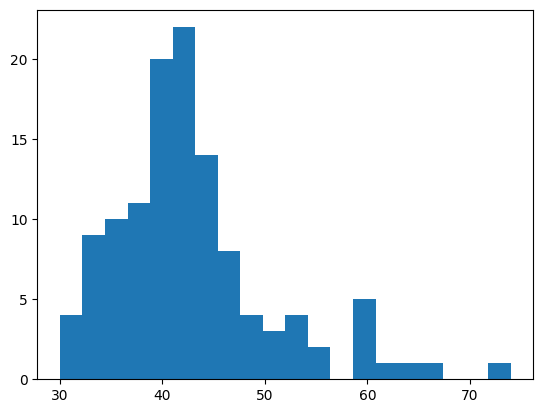

In [8]:
wc = [len(x.split(' ')) for x in summaries_list]
import matplotlib.pyplot as plt
plt.hist(wc, bins=20)
plt.show()

In [12]:
# an example nle question
choices = ['positive', 'negative']

def prediction_function(input_premise, is_query=False, n_reviews=None):
    if is_query:
        query = input_premise
        n_reviews = n_reviews
    else:
        query = []
        for i, x in enumerate(input_premise):
            query.append(f">>>Review {i} starts\n{x}\n>>>Review {i} ends\n")
        query = "".join(query)
        n_reviews = len(input_premise)
    # print(query)
    sys_msg = f"""
    What is the sentiment of the following reviews?
    For each review, provide the probabilities of each choices from {choices} and explain your reasoning.
    Note: Treat each review independently. The start and end of an review is marked by ">>>Review i starts" and ">>>Review i ends" where i is the number. The notion "[MASK]" means a missing word.

    Reply in the following format: 
    The reply to each review contains 3 lines.
    The first line contains the probabilities of each choice seperated by a space,
    and the second line is the explanation, which should not contain any special character.
    The third line is a seperator "---" marking the end of the reply.
    There should be no new line between consecutive replies.
    
    If you cannot decide, please still guess a probability for each choice and explain why you cannot decide.
    The followings are examples of a valid response that contains 4 replies, followed by 4 lines of "---":
    0.15 0.85
    your explanation
    ---
    0.5 0.5
    your explanation
    ---
    0.68 0.32
    your explanation
    ---
    0.71 0.29
    your explanation
    ---
    """

    response = openai.ChatCompletion.create(
        messages=[
            {'role': 'system', 'content': sys_msg},
            {'role': 'user', 'content': query},
        ],
        model=GPT_MODEL,
        temperature=0,
    )

    model_response = response['choices'][0]['message']['content']
    reply_counts = model_response.count("\n---")
    try:
        assert reply_counts == n_reviews
    except AssertionError:
        print(">>>>>>>>>>>>AssertionError:")
        print(f"number of replies {reply_counts} does not match number of reviews {n_reviews}")
        print(query)
        print(model_response)
        raise AssertionError

    y_prob_list, model_nle_list = [], []
    model_response += '\n'
    for line in model_response.split("\n---\n")[:-1]:
        try:
            y_prob, model_nle = line.split('\n')
            y_prob = [float(p) for p in y_prob.split(' ')]
            y_prob_list.append(y_prob)
            model_nle_list.append(model_nle)
        except:
            print(">>>>>>>>>>>>Exception: model reply in wrong format for one reply")
            print(query)
            print(model_response)
            # y_prob_list.append([0.5, 0.5])
            # model_nle_list.append("Unknown")
            raise AssertionError
    return y_prob_list, model_nle_list

# SHAP_function("I love this movie, but I don't like the ending. Still it is a good movie.")
# SHAP_function("I ? this movie, but I don't ? the ending. Still it is a ? movie.")
# SHAP_function(df.review[5])
import scipy as sp
import time
import requests

current_request_count = 0
current_token_count = 0
def f(x, batch_size=10):
    outputs = []
    for i in range(0,len(x),batch_size):
        _x = x[i:i+batch_size]
        success = False
        n_trials = 5
        while n_trials > 0:
            try:
                if time.time() - globals()['current_time'] < 10 and globals()['current_request_count'] > 32:
                    print('request hits limit')
                    time.sleep(5)
                    globals()['current_time'] = time.time()
                    globals()['current_request_count'] = 0
                y_prob_list, _ = prediction_function(_x)
                time.sleep(5)
                globals()['current_request_count'] += 1
                success = True
                break
            except AssertionError:
                print("retrying")
                n_trials -= 1
                continue
            except TimeoutError or requests.exceptions.Timeout or requests.exceptions.readTimeout or socket.timeout:
                print("time out and sleep")
                time.sleep(60)
                continue
        if success == False:
            raise AssertionError("model reply in wrong format")
        outputs.extend(y_prob_list)
    outputs = np.array(outputs)
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val


import tiktoken
import shap
from functools import partial
from tqdm.auto import tqdm

class tokenizer:
    def __init__(self) -> None:
        self.tokenizer = tiktoken.encoding_for_model(GPT_MODEL)
    def __call__(self, x):
        return {"input_ids":self.tokenizer.encode(x)}
    def decode(self, x):
        return self.tokenizer.decode(x)

tok = tokenizer()
shap_tok = shap.maskers.Text(tok, mask_token='[MASK]', collapse_mask_token=False)

sample_df = pd.read_csv('movies_120.csv')
sample_df['shap_values'] = [np.zeros(1).astype('object')]*len(sample_df)
sample_df['shap_base_values'] = [np.zeros(1).astype('object')]*len(sample_df)
sample_df['shap_base_values'].astype('object')
sample_df['shap_data'] =[np.zeros(1).astype('object')]*len(sample_df)
sample_df['y_prob'] =[np.zeros(1).astype('object')]*len(sample_df)
sample_df['model_nle'] =[np.zeros(1).astype('object')]*len(sample_df)

start_i = 2
if start_i >= 1:
    sample_df = pd.read_csv(f'movies_120_shap_{start_i-1}.csv')

import socket
current_time = time.time()
for i in tqdm(range(start_i,len(sample_df))):
    time.sleep(60)
    current_review_summary = sample_df.review[i]
    explainer = shap.Explainer(partial(f, batch_size=8), masker=shap_tok, output_names=choices)
    y_prob, model_nle = prediction_function([current_review_summary])
    # shap_values = explainer([current_review_summary], max_evals=64)
    shap_values = explainer([current_review_summary], batch_size=8, max_evals=128)
    sample_df.loc[i, 'shap_values'] = shap_values.values.tolist()
    sample_df.loc[i, 'shap_base_values'] = np.array([shap_values.base_values]).tolist()
    sample_df.loc[i, 'shap_data'] = np.array([shap_values.data]).tolist()
    sample_df.loc[i, 'y_prob'] = np.array([y_prob]).tolist()
    sample_df.loc[i, 'model_nle'] = np.array(model_nle).astype('object')
    sample_df.to_csv(f'movies_120_shap_{i}.csv', index=False)
    print(f"finish review {i+1} \r")

# f(["This book is pretty interesting but it's too long", "This book is pretty interesting but it's too [MASK]"])

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)

socket.timeout

In [198]:
shap_values.values.tolist()

[[[-0.003124999999999996, 0.0031249999999999993],
  [-0.003124999999999996, 0.0031249999999999993],
  [-0.003124999999999996, 0.0031249999999999993],
  [-0.003124999999999996, 0.0031249999999999993],
  [-0.003124999999999996, 0.0031249999999999993],
  [-0.003124999999999996, 0.0031249999999999993],
  [-0.003124999999999996, 0.0031249999999999993],
  [-0.003124999999999996, 0.0031249999999999993],
  [0.007187500000000005, -0.007187499999999998],
  [0.007187500000000005, -0.007187499999999998],
  [0.019687499999999983, -0.01968750000000001],
  [0.044687499999999984, -0.044687500000000005],
  [-0.020937499999999987, 0.020937499999999998],
  [-0.020937499999999987, 0.020937499999999998],
  [-0.07458333333333335, 0.0745833333333333],
  [-0.07458333333333335, 0.0745833333333333],
  [-0.07458333333333335, 0.0745833333333333],
  [-0.038125000000000006, 0.038125],
  [-0.0034374999999999918, 0.0034374999999999996],
  [-0.0034374999999999918, 0.0034374999999999996],
  [-0.0128125, 0.0128124999999

In [177]:
y_prob, model_nle = prediction_function([current_review_summary])


In [195]:
sample_df = pd.read_csv('movies_120.csv')
sample_df['shap_values'] = [np.zeros(1).astype('object')]*len(sample_df)
sample_df['shap_base_values'] = [np.zeros(1).astype('object')]*len(sample_df)
sample_df['shap_base_values'].astype('object')
sample_df['shap_data'] =[np.zeros(1).astype('object')]*len(sample_df)
sample_df['y_prob'] =[np.zeros(1).astype('object')]*len(sample_df)
sample_df['model_nle'] =[np.zeros(1).astype('object')]*len(sample_df)
sample_df

,review,label,shap_values,shap_base_values,shap_data,y_prob,model_nle
0,The movie is a teen mind-fuck that presents a ...,negative,[0.0],[0.0],[0.0],[0.0],[0.0]
1,"""Virus"" is a movie that goes for all flash and...",negative,[0.0],[0.0],[0.0],[0.0],[0.0]
2,"""The Mod Squad"" is a slick looking production ...",positive,[0.0],[0.0],[0.0],[0.0],[0.0]
3,"""Quest for Camelot"" is Warner Bros.' first fea...",negative,[0.0],[0.0],[0.0],[0.0],[0.0]
4,"""Stalked"" is yet another in a seemingly endles...",negative,[0.0],[0.0],[0.0],[0.0],[0.0]
...,...,...,...,...,...,...,...
115,"""Get Carter"" is a disappointing action film, w...",negative,[0.0],[0.0],[0.0],[0.0],[0.0]
116,"""Down to Earth"" is a mediocre remake of ""Heave...",negative,[0.0],[0.0],[0.0],[0.0],[0.0]
117,"""Hollow Man"" is a disturbing and unsophisticat...",negative,[0.0],[0.0],[0.0],[0.0],[0.0]
118,"""Sexy Beast"" is a stylish British gangster fil...",positive,[0.0],[0.0],[0.0],[0.0],[0.0]


In [196]:
i = 0
sample_df.loc[i, 'shap_values'] = shap_values.values.tolist()
sample_df.loc[i, 'shap_base_values'] = np.array([shap_values.base_values]).tolist()
sample_df.loc[i, 'shap_data'] = np.array([shap_values.data]).tolist()
sample_df.loc[i, 'y_prob'] = np.array([y_prob]).tolist()
sample_df.loc[i, 'model_nle'] = np.array(model_nle).astype('object')
sample_df

,review,label,shap_values,shap_base_values,shap_data,y_prob,model_nle
0,The movie is a teen mind-fuck that presents a ...,negative,"[[[0.004687499999999994, -0.004687499999999999...","[[[0.0, 0.0]]]","[[[The, movie, is, a, teen, mind, -...","[[[0.1, 0.9]]]",[The review is negative. The reviewer criticiz...
1,"""Virus"" is a movie that goes for all flash and...",negative,[0.0],[0.0],[0.0],[0.0],[0.0]
2,"""The Mod Squad"" is a slick looking production ...",positive,[0.0],[0.0],[0.0],[0.0],[0.0]
3,"""Quest for Camelot"" is Warner Bros.' first fea...",negative,[0.0],[0.0],[0.0],[0.0],[0.0]
4,"""Stalked"" is yet another in a seemingly endles...",negative,[0.0],[0.0],[0.0],[0.0],[0.0]
...,...,...,...,...,...,...,...
115,"""Get Carter"" is a disappointing action film, w...",negative,[0.0],[0.0],[0.0],[0.0],[0.0]
116,"""Down to Earth"" is a mediocre remake of ""Heave...",negative,[0.0],[0.0],[0.0],[0.0],[0.0]
117,"""Hollow Man"" is a disturbing and unsophisticat...",negative,[0.0],[0.0],[0.0],[0.0],[0.0]
118,"""Sexy Beast"" is a stylish British gangster fil...",positive,[0.0],[0.0],[0.0],[0.0],[0.0]


In [192]:
sample_df.to_csv('shap_value.csv', index=False)
some_df = pd.read_csv('shap_value.csv')
# np.fromstring()
import ast
ast.literal_eval(some_df.loc[0, 'y_prob'])

[[[0.1, 0.9]]]

In [171]:
shap_values

shap.plots.text(shap_values, grouping_threshold=0.005)

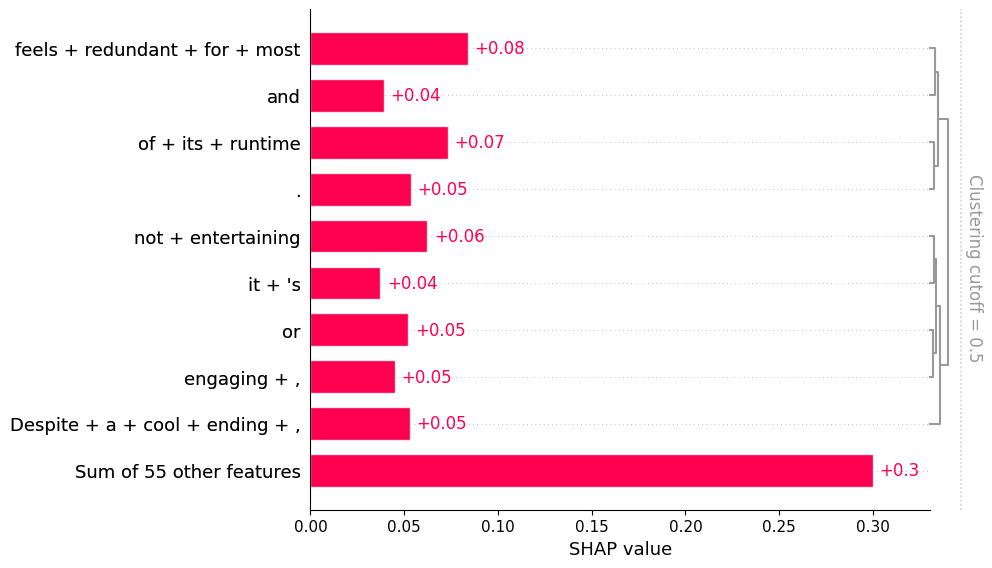

In [172]:
shap.plots.bar(shap_values[0,:,'negative'], clustering_cutoff=0.5)

## Obtain NLE Embeddings

In [173]:
import torch
roberta = torch.hub.load('pytorch/fairseq', 'roberta.large', verbose=0)
roberta.eval()  # disable dropout (or leave in train mode to finetune)
roberta.to('cuda')

2023-06-29 00:54:48 | INFO | fairseq.file_utils | loading archive file http://dl.fbaipublicfiles.com/fairseq/models/roberta.large.tar.gz from cache at C:\Users\sonne\.cache\torch\pytorch_fairseq\83e3a689e28e5e4696ecb0bbb05a77355444a5c8a3437e0f736d8a564e80035e.c687083d14776c1979f3f71654febb42f2bb3d9a94ff7ebdfe1ac6748dba89d2


Unable to build Cython components. Please make sure Cython is installed if the torch.hub model you are loading depends on it.


hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()

The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
hydra.experimental.compose() is no longer experimental. Use hydra.compose()
In 'config': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/changes_to_package_header for more information

'config' is validated against ConfigStore schema with the same name.
This behavior is deprecated in Hydra 1.1 and will be removed in Hydra 1.2.
See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/automatic_schema_matching for migration instructions.

The strict flag in the compose API is deprecated.
See https://hydra.cc/docs/1.2/upgrades/0.11_to_1.0/strict_mode_flag_deprecated for more info.

hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()

The version_base parameter is not specified.
Ple

RobertaHubInterface(
  (model): RobertaModel(
    (encoder): RobertaEncoder(
      (sentence_encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(50265, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(514, 1024, padding_idx=1)
        (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0-23): 24 x TransformerEncoderLayerBase(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
       

In [174]:
to_tok = list(df_cose.columns)
for x in ['id', 'label']:
    to_tok.remove(x)
tok_df_cose = df_cose.copy()
tok_df_cose[to_tok] = tok_df_cose[to_tok].apply(lambda x: [roberta.encode(str(s)) for s in x])
tok_df_cose

NameError: name 'df_cose' is not defined

In [ ]:

tok_model_nle = roberta.encode(model_nle)
tok_choices = [roberta.encode(ch) for ch in choices]

# embed the tokens using the last layer feature of the model
emb_model_nle = roberta.extract_features(tok_model_nle)
tok_choices = [roberta.extract_features(ch) for ch in tok_choices]


## Calculate SHAP Score

In [ ]:
import transformers
import shap
model = transformers.pipeline('sentiment-analysis', return_all_scores=True)

text_data = "This book is pretty interesting but it's too long"

explainer = shap.Explainer(model) 
shap_values = explainer([text_data])
shap_values

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


.values =
array([[[ 0.        ,  0.        ],
        [-0.01345348,  0.01345348],
        [ 0.00926322, -0.00926323],
        [-0.01751831,  0.01751831],
        [-0.05586129,  0.05586129],
        [-0.39003555,  0.39003555],
        [ 0.15331828, -0.15331826],
        [-0.04646818,  0.04646816],
        [-0.06173874,  0.06173873],
        [ 0.04031968, -0.04031966],
        [ 0.36652539, -0.36652541],
        [ 0.34822644, -0.34822645],
        [ 0.        ,  0.        ]]])

.base_values =
array([[0.66618073, 0.3338193 ]])

.data =
(array(['', 'This ', 'book ', 'is ', 'pretty ', 'interesting ', 'but ',
       'it', "'", 's ', 'too ', 'long', ''], dtype=object),)

In [ ]:
import transformers
import shap
import torch

device = torch.device('cuda:0')
# load the model
pmodel = transformers.pipeline('question-answering', device=device)

# define two predictions, one that outputs the logits for the range start,
# and the other for the range end
def f(questions, start):
    outs = []
    for q in questions:
        print(q)
        question, context = q.split("[SEP]")
        d = pmodel.tokenizer(question, context)
        out = pmodel.model.forward(**{k: torch.tensor(d[k]).reshape(1, -1).to(device) for k in d})
        logits = out.start_logits if start else out.end_logits
        outs.append(logits.reshape(-1).cpu().detach().numpy())
    return outs

def f_start(questions):
    return f(questions, True)
def f_end(questions):
    return f(questions, False)

# attach a dynamic output_names property to the models so we can plot the tokens at each output position
def out_names(inputs):
    question, context = inputs.split("[SEP]")
    d = pmodel.tokenizer(question, context)
    return [pmodel.tokenizer.decode([id]) for id in d["input_ids"]]
f_start.output_names = out_names
f_end.output_names = out_names

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
data = ["What is on the table?[SEP]When I got home today I saw my cat on the table, and my frog on the floor."]
# pmodel.tokenizer(data, mask=)
import tiktoken
enc = tiktoken.encoding_for_model("gpt-4-0613")
len(enc.encode(data[0]))

28

In [ ]:
data

['What is on the table?[SEP]When I got home today I saw my cat on the table, and my frog on the floor.']

In [ ]:
data = ["What is on the table?[SEP]When I got home today I saw my cat on the table, and my frog on the floor."]
pmodel.tokenizer.mask_token_id

103

In [ ]:
pmodel.tokenizer(data)


{'input_ids': [[101, 1327, 1110, 1113, 1103, 1952, 136, 102, 1332, 146, 1400, 1313, 2052, 146, 1486, 1139, 5855, 1113, 1103, 1952, 117, 1105, 1139, 13670, 1113, 1103, 1837, 119, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
data = ["What is on the table?[SEP]When I got home today I saw my cat on the table, and my frog on the floor."]

# explainer_start = shap.Explainer(f_start, pmodel.tokenizer)
# explainer_start = shap.Explainer(f_start, pmodel.tokenizer)
class tokenizer:
    def __init__(self) -> None:
        self.tokenizer = pmodel.tokenizer
    def __call__(self, x):
        return {"input_ids":pmodel.tokenizer(x)['input_ids']}
    def decode(self, x):
        return pmodel.tokenizer.decode(x)
tok = shap.maskers.Text(tokenizer(), mask_token='...', collapse_mask_token=True)


# explainer_start = shap.Explainer(f_start, masker=tok)
explainer_start = shap.Explainer(f_start, pmodel.tokenizer)


shap_values_start = explainer_start(data, batch_size=1)

shap.plots.text(shap_values_start)

TypeError: __call__() got an unexpected keyword argument 'progress_bar'

: 

In [ ]:
data = ["What is on the table?[SEP]When I got home today I saw my cat on the table, and my frog on the floor."]
def make_answer_scorer(answers):
    def f(questions):
        out = []
        for q in questions:
            question, context = q.split("[SEP]")
            results = pmodel(question, context, top_k=20)
            values = []
            for answer in answers:
                value = 0
                for result in results:
                    if result["answer"] == answer:
                        value = result["score"]
                        break
                values.append(value)
            out.append(values)
        return out
    f.output_names = answers
    return f

f_answers = make_answer_scorer(["my cat", "cat", "my frog"])

explainer_answers = shap.Explainer(f_answers, pmodel.tokenizer)
shap_values_answers = explainer_answers(data)

shap.plots.text(shap_values_answers)

In [ ]:
shap_values_answers

.values =
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.69124413e-02, -5.52253337e-02,  8.65240455e-03],
        [-1.34780238e-02, -4.12751370e-02, -1.56310292e-02],
        [ 2.09620141e-03,  5.29225320e-02, -2.64582045e-02],
        [ 4.88220479e-02,  6.25952940e-02, -2.01617490e-02],
        [ 1.39899513e-01,  1.11438790e-01, -8.14635345e-02],
        [ 1.25926260e-02,  4.20484598e-02,  1.09544975e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.52645899e-03, -3.15239110e-03,  8.66274782e-04],
        [ 3.52645899e-03, -3.15239110e-03,  8.66274782e-04],
        [ 3.20395688e-03, -1.45857349e-02,  4.32692908e-03],
        [ 3.20395688e-03, -9.66237406e-03,  4.04172768e-03],
        [ 3.94194270e-03,  2.23734954e-02, -5.09236679e-03],
        [ 3.94194270e-03,  2.25603571e-02, -3.52081549e-03],
        [-6.36603909e-04, -2.52694754e-02,  2.20085294e-03],
        [ 1.13435351e-01,  3.38443481e-02, -7.09942254e-03],
        [ 4.24

In [ ]:
len(shap_values_answers.data[0])

29